### Playback walk motion

In [1]:
import time,pickle,mujoco
import numpy as np
import cv2,glob,os
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from util import rpy2r,MultiSliderClass,create_folder_if_not_exists
import mediapy as media

np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.7]


### Parse

In [2]:
xml_path = '../asset/common_rig/scene_common_rig_v2.xml'
env = MuJoCoParserClass(name='Common Rig',rel_xml_path=xml_path,VERBOSE=False)
# Modify the color of body exluding 'world'
for body_name in env.body_names:
    if body_name in ['world']: continue
    body_idx = env.body_names.index(body_name)
    geom_idxs = [idx for idx,val in enumerate(env.model.geom_bodyid) if val==body_idx]
    for geom_idx in geom_idxs:
        env.model.geom(geom_idx).rgba = [0.9,0.9,0.9,0.5]
print ("Done.")

Done.


### Load walking motion

In [3]:
pkl_path = '../data/common_rig_cmu_walk.pkl'
with open(pkl_path, 'rb') as f:
    data = pickle.load(f)
qs         = data['qpos'] # [299 x 42]
# quat_roots = data['rotation'][:,0,:]
p_roots    = data['root']
L = qs.shape[0]
HZ = 10
times = np.linspace(0,HZ/L,L)
print ("[%s] loaded."%(pkl_path))

[../data/common_rig_cmu_walk.pkl] loaded.


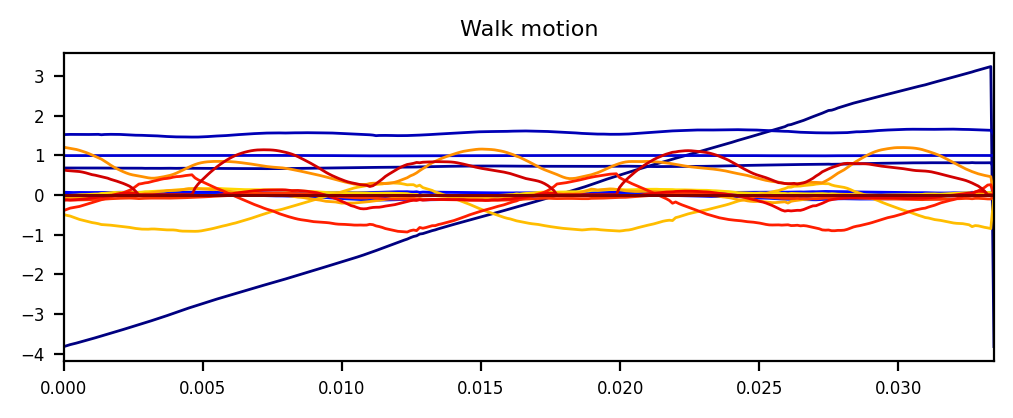

In [4]:
plt.figure(figsize=(6,2))
colors = plt.get_cmap('jet')(np.linspace(0,1,qs.shape[1]))
for i_idx in range(qs.shape[1]):
    plt.plot(times,qs[:,i_idx],'-',lw=1,color=colors[i_idx])
plt.xlim([times[0],times[-1]])
plt.title('Walk motion',fontsize=8)
plt.show()

In [5]:
# Set which joints to control
rev_joint_names = env.rev_joint_names
joint_idxs_fwd = env.get_idxs_fwd(joint_names=rev_joint_names)
joint_idxs_jac = env.get_idxs_jac(joint_names=rev_joint_names)
q_rev_init = env.get_qpos_joints(rev_joint_names)
n_rev_joint = len(rev_joint_names)

In [6]:
qrev_sliders = MultiSliderClass(
    n_slider      = n_rev_joint,
    title         = 'Joint position slider',
    window_width  = 500,
    window_height = 800,
    x_offset      = 100,
    y_offset      = 200,
    slider_width  = 350,
    label_texts   = rev_joint_names,
    slider_mins   = env.rev_joint_mins,
    slider_maxs   = env.rev_joint_maxs,
    slider_vals   = q_rev_init,
    resolution    = 0.01,
    VERBOSE       = False
)

tick_slider = MultiSliderClass(
    n_slider      = 1,
    title         = 'Tick slider',
    window_width  = 500,
    window_height = 100,
    x_offset      = 100,
    y_offset      = 0,
    slider_width  = 350,
    label_texts   = ['Tick'],
    slider_mins   = [0],
    slider_maxs   = [L-1],
    slider_vals   = [0],
    resolution    = 0.5,
    ADD_PLAYBACK  = True,
    VERBOSE       = False
)
print ("Slider ready.")

Slider ready.


In [7]:
joint_idxs_fwd

[7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41]

In [8]:
# Configuration
PLOT_EVERY = 4
SAVE_VID   = True
print ("PLOT_EVERY:[%d] SAVE_VID:[%d]"%(PLOT_EVERY,SAVE_VID))

PLOT_EVERY:[4] SAVE_VID:[1]


### Loop

2023-12-21 11:00:55.711 python[23490:1376955] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


Pressed ESC
Quitting.


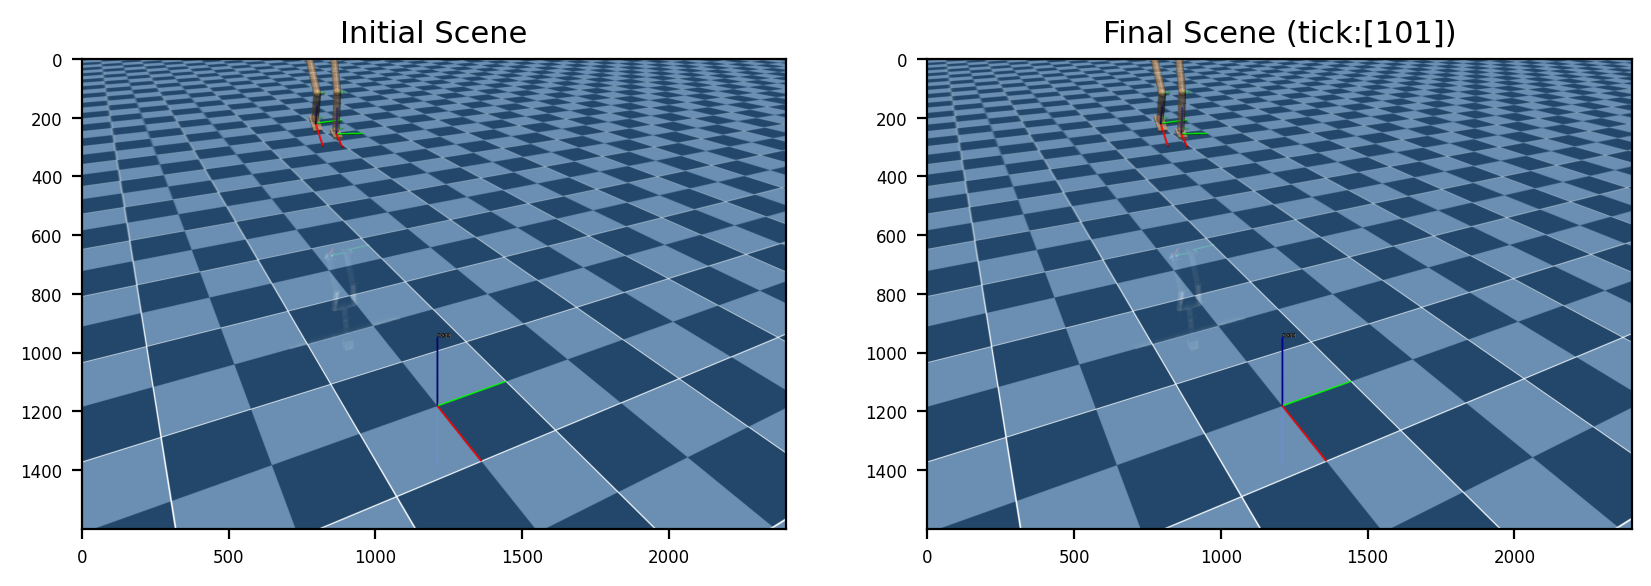

Done.


In [9]:
# Initialize MuJoCo viewer
env.init_viewer(viewer_title='Common Rig',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=152,distance=3.0,elevation=-30,lookat=[0.02,-0.03,0.8])
env.reset()
FIRST_FLAG = True
while env.is_viewer_alive():
    
    # Update
    time.sleep(1e-10) # little delay helps
    qrev_sliders.update()
    tick_slider.update()
    if tick_slider.PLAYBACK: # play mode
        tick = min(tick+1,L-1)
        if tick == (L-1): tick_slider.reset_playback()
        tick_slider.set_slider_values([tick])
    else: # stop mode
        slider_val = tick_slider.get_slider_values()
        tick = int(slider_val[0])
    qrev_sliders.set_slider_values(qs[tick,:]) # set q slider
    
    # FK
    q         = qs[tick,:] # [35]
    p_root    = p_roots[tick,:] # [3]
    quat_root = q[3:7] # [4] quaternion
    env.set_p_root(root_name='base',p=p_root)
    # env.set_quat_root(root_name='base',quat=quat_root[[3,0,1,2]])
    env.forward(q=q[7:],joint_idxs=joint_idxs_fwd)
    
    # Render
    if env.loop_every(tick_every=100) or tick_slider.PLAYBACK:
        # Plot world frame
        env.plot_T(p=np.zeros(3),R=np.eye(3,3),
                   PLOT_AXIS=True,axis_len=0.5,axis_width=0.005)
        env.plot_T(p=np.array([0,0,0.5]),R=np.eye(3,3),
                   PLOT_AXIS=False,label="tick:[%d]"%(tick))
        # Plot foot
        env.plot_geom_T(geom_name='rfoot',axis_len=0.3)
        env.plot_geom_T(geom_name='lfoot',axis_len=0.3)
        # Plot revolute joints with arrow
        env.plot_joint_axis(axis_len=0.1,axis_r=0.01)
        env.render()
        
    # Save image
    if env.is_viewer_alive() and FIRST_FLAG:
        scene_img_init = env.grab_image()
        scene_img_final = scene_img_init.copy()
        FIRST_FLAG = False
    if env.is_viewer_alive() and env.loop_every(tick_every=1000):
        scene_img_final = env.grab_image()

    if SAVE_VID:
        # Save iamges
        png_path = '../temp/cmu_common_rig_walk_%05d.png'%(env.tick)
        create_folder_if_not_exists(png_path)
        image = cv2.cvtColor(env.grab_image(),cv2.COLOR_RGB2BGR)
        cv2.imwrite(png_path,image)

    
# Close MuJoCo viewer
env.close_viewer()
qrev_sliders.close()

# Plot initial and final scenes
fig,axs = plt.subplots(1,2,figsize=(10,4))
plt.subplots_adjust(top=0.85,bottom=0.15,wspace=0.2,hspace=0.5)
axs[0].imshow(scene_img_init)
axs[0].set_title('Initial Scene',fontsize=11)
axs[1].imshow(scene_img_final)
axs[1].set_title('Final Scene (tick:[%d])'%(env.tick),fontsize=11)
plt.show()
print ("Done.")

In [10]:
if SAVE_VID:
    # Show video
    png_paths = sorted(glob.glob('../temp/cmu_common_rig_walk_*.png'))
    frames = []
    for png_path in png_paths:
        img_bgr = cv2.imread(png_path)
        img_rgb = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)
        frames.append(img_rgb)
    media.show_video(images=frames,fps=int(1/env.dt/PLOT_EVERY),width=500)
    # Save video to mp4
    vid_path = '../vid/kin_chain.mp4'
    create_folder_if_not_exists(vid_path)
    media.write_video(images=frames,fps=int(1/env.dt/PLOT_EVERY),path=vid_path)
    print ("[%s] saved."%(vid_path))

[../vid] created.
[../vid/kin_chain.mp4] saved.


: 

In [ ]:
# Remove existing images
png_paths = sorted(glob.glob('../temp/cmu_common_rig_walk_*.png'))
for png_path in png_paths:
    os.remove(png_path)
print ("[%d] images removed."%(len(png_paths)))